In [117]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sn
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sallers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','Order_items') # Added payments.csv for specific handling
]

In [118]:
# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Komal@7037',
    database='ecommerce',
    auth_plugin='mysql_native_password'
)
cursor = conn.cursor()

In [119]:
# Folder containing the CSV files
folder_path = r'C:\Users\raksh\OneDrive\Desktop\Ecommers Data'

In [120]:


def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

In [121]:
for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [122]:
db = mysql.connector.connect(host = "localhost",
                             user = "root",
                             password = "Komal@7037",
                             database = "ecommerce",
                             auth_plugin='mysql_native_password'
                             )
cur = db.cursor()

# List all unique cities where customers are located.

In [142]:
query = """select distinct upper(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns= ['City'])
df

,City
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
...,...
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL


# Count the number of orders placed in 2017.

In [146]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

90202

# Find the total sales per category.

In [157]:
query = """select upper(products.product_category) as category, round(sum(payments.payment_value),2) as sales 
from products join order_items 
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id 
group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Category","Sales"])
df.head(10)

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
5,COMPUTER ACCESSORIES,12682643.57
6,HOUSEWARES,8758065.04
7,BABIES,4318765.28
8,TOYS,4952301.52
9,FURNITURE OFFICE,5174611.90


# Calculate the percentage of orders that were paid in installments.

In [126]:
query = """select sum( case when payment_installments >= 1 then 1 else 0 end)/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9981')

# Count the number of customers from each state. 

In [127]:
query = """select count(customers.customer_id) as Customers, upper(customers.customer_state) as State 
from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns= ["Total Customers","State"])
df.sort_values(by='Total Customers', ascending = False)
df.head()

,Total Customers,State
0,83492,SP
1,7274,SC
2,23270,MG
3,10090,PR
4,25704,RJ


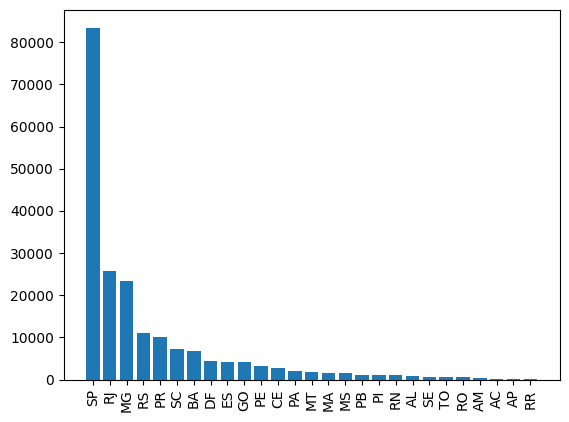

In [128]:

df1 = df.sort_values(by='Total Customers', ascending = False)
plt.figure
plt.bar(df1['State'],df1['Total Customers'])
plt.xticks(rotation = 90)
plt.show()

#  Calculate the number of orders per month in 2018.

In [150]:


query = """select count(orders.order_id) as Total_order , monthname(orders.order_purchase_timestamp) as Month_name from orders
where year(order_purchase_timestamp)= 2017
group by Month_name"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data,columns=['Total_order','Month_name'])
df

,Total_order,Month_name
0,9262,October
1,15088,November
2,8052,July
3,4808,April
4,7400,May
5,1600,January
6,11346,December
7,8570,September
8,8662,August
9,5364,March


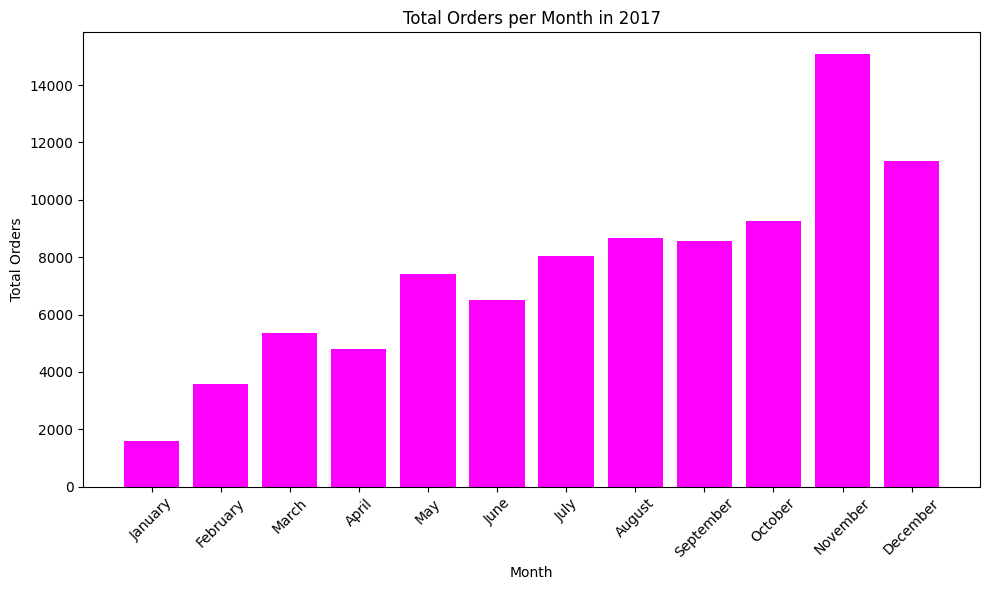

In [152]:

month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df['Month_name'] = pd.Categorical(df['Month_name'], categories=month_order, ordered=True)
df = df.sort_values('Month_name')


plt.figure(figsize=(10, 6))
plt.bar(df['Month_name'], df['Total_order'], color='magenta')
plt.title('Total Orders per Month in 2017')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Find the average number of products per order, grouped by customer city

In [156]:

query = """with count_per_order as
(select orders.order_id , orders.customer_id, count(order_items.order_id) as ordercount
from orders
join order_items
on orders.order_id  = order_items.order_id
group by orders.order_id , orders.customer_id)
select customers.customer_city, round(avg(count_per_order.ordercount),2) as average_orders
from customers
join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns= ['Customer City','Average Order'])
df.head(10)

,Customer City,Average Order
0,sao paulo,4.62
1,sao jose dos campos,4.55
2,porto alegre,4.70
3,indaial,4.46
4,treze tilias,5.09
5,rio de janeiro,4.59
6,mario campos,5.33
7,guariba,4.00
8,cuiaba,4.79
9,franca,5.01


# Calculate the total revenue generated by each seller.

In [155]:


query = """select sum(payments.payment_value) as Revenue , customers.customer_city as City
from payments
join orders
on orders.order_id = payments.order_id
join customers
on customers.customer_id = orders.customer_id
group by customers.customer_city
"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns= ['Revenue','City'])
df.head(10)

,Revenue,City
0,1.762698e+07,sao paulo
1,3.350960e+03,valentim gentil
2,2.713032e+04,pedreira
3,4.628880e+03,carmo da mata
4,3.299002e+05,taboao da serra
5,2.315883e+05,americana
6,9.639152e+04,araguari
7,4.568268e+05,uberlandia
8,9.589078e+05,fortaleza
9,9.295419e+06,rio de janeiro
